# Recreating @idatadrew's implementation which can be found [here](https://public.tableau.com/views/NHL-ChangeinAverageAttendanceperGame/NHL-ChangeinAverageAttendanceperGame?:embed=y&:display_count=yes&publish=yes&:toolbar=no&:showVizHome=no).

## What is the % change in average attendance per game for NHL teams compared to the 2000-01 season?

In [1]:
import math
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None #surpress is copy warning

In [2]:
df = pd.read_csv('./NHL Attendance.csv')
df.columns

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')

In [3]:
df = df.query('TEAM != "Vegas"')
print(df.groupby('TEAM')['SEASON'].count())

TEAM
Anaheim         17
Arizona         17
Boston          17
Buffalo         17
Calgary         17
Carolina        17
Chicago         17
Colorado        17
Columbus        17
Dallas          17
Detroit         17
Edmonton        17
Florida         17
Los Angeles     17
Minnesota       17
Montreal        17
NY Islanders    17
NY Rangers      17
Nashville       17
New Jersey      17
Ottawa          17
Philadelphia    17
Pittsburgh      17
San Jose        17
St. Louis       17
Tampa Bay       17
Toronto         17
Vancouver       17
Washington      17
Winnipeg        17
Name: SEASON, dtype: int64


In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

def format_percent(season_one, season_two):
    percent = season_one / season_two;
    percent = percent - 1
    return round(percent * 100, 1)

def calculate_percent_change(current_attendance, team, df):
    row = df.query('SEASON == "2000-01" and TEAM == @team')
    starting_attendance = row.iloc[0]['AVERAGE ATTENDANCE PER GAME']

    return format_percent(current_attendance, starting_attendance)

In [5]:
data = df[['TEAM', 'SEASON', ' TOTAL ATTENDANCE ', 'TOTAL GAMES']]
data = clean_numeric_column(data, ' TOTAL ATTENDANCE ')


data['AVERAGE ATTENDANCE PER GAME'] = round(data[' TOTAL ATTENDANCE '] / data['TOTAL GAMES'], 0)
data['PREVIOUS AVERAGE ATTENDANCE PER GAME'] = data.groupby('TEAM')['AVERAGE ATTENDANCE PER GAME'].shift(-1)

data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'] = data.apply(lambda row: 
    calculate_percent_change(
        row['AVERAGE ATTENDANCE PER GAME'],
        row['TEAM'],
        data
    ),
    axis = 1, #applies lambda to row                                                                 
)

data = data.query('SEASON != "2000-01"')
data['SEASON'] = data['SEASON'].str[2:] # remove leading 20
piviot_table = pd.pivot_table(data, values='PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME', index='TEAM',  columns='SEASON')


In [6]:
def sort_teams(df):
    result = df.groupby('TEAM')['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'].sum().reset_index()
    result = df.sort_values(by=['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'], ascending=False)
    result = result['TEAM'].unique().tolist()
    return result

team_order = sort_teams(data)
piviot_table = piviot_table.reindex(team_order, axis=0)
print(piviot_table.query('TEAM == "Chicago"'))

SEASON   01-02  02-03  03-04  05-06  06-07  07-08  08-09  09-10  10-11  11-12  \
TEAM                                                                            
Chicago    2.6    0.9   -4.3   -5.0   -7.0    8.0   25.8   21.8   24.3   23.7   

SEASON   12-13  13-14  14-15  15-16  16-17  17-18  
TEAM                                               
Chicago   26.3   27.9   27.8   28.9   27.5   24.3  


Average attendance per game has steadily increased **compared to the 2000-01 season** for most teams. Chiago Blackhawks have seen the most <font color=blue>**positive % change**</font>, whereas Colorado Avalanche have seen the most <font color=red>**negative % change**</font>.

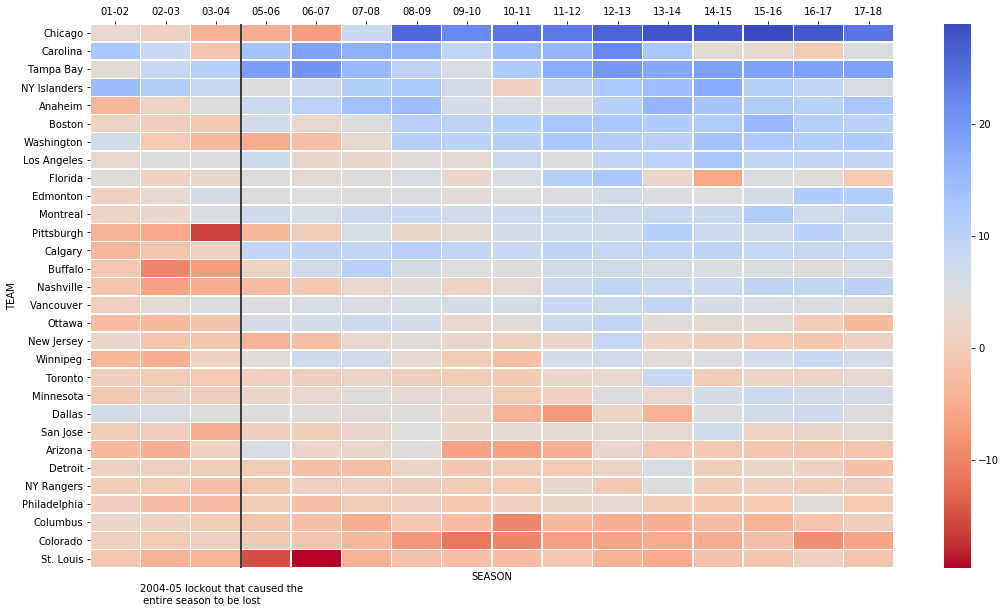

In [19]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(piviot_table, linewidth=0.5, cmap="coolwarm_r")
ax.xaxis.tick_top()
ax.vlines(3, *ax.get_ylim()) # lockout

ax.annotate('2004-05 lockout that caused the\n entire season to be lost', xy=(1, 1), xytext=(1, 32))


plt.show()

TODO:
    add lines with notes about lockouts
    display as percent instead of numbers
    format seasons and move labels to top
    remove team
    add Season (2000's)
    display hot cold metere as % with max min range
    add hockey stick man to markdown :D